# Label transfer with scPoli

In [1]:
!pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [2]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from scarches.models.scpoli import scPoli
import scvi

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

/home/aih/sara.jimenez/miniconda3/envs/scarches/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


In [3]:
sc.settings.set_figure_params(dpi=100, frameon=False)
sc.set_figure_params(dpi=100)
sc.set_figure_params(figsize=(3, 3))
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (3, 3)

In [4]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

INFO: [rank: 0] Seed set to 0
INFO:lightning.fabric.utilities.seed:[rank: 0] Seed set to 0


Last run with scvi-tools version: 1.1.2


### Load data

In [5]:
folder = '/lustre/groups/ml01/workspace/hpca_sara.jimenez_shrey.parikh/initial_data/charite_snRNA/h5ad_file/'
file   = 'adult_pancreas_2020.h5ad'

adata_tosti  = sc.read(filename = folder+file)
adata_tosti

AnnData object with n_obs × n_vars = 112563 × 43815
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_ID', 'patient_ID', 'sex', 'age', 'pancreas_location', 'procurement_lab', 'Cluster'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

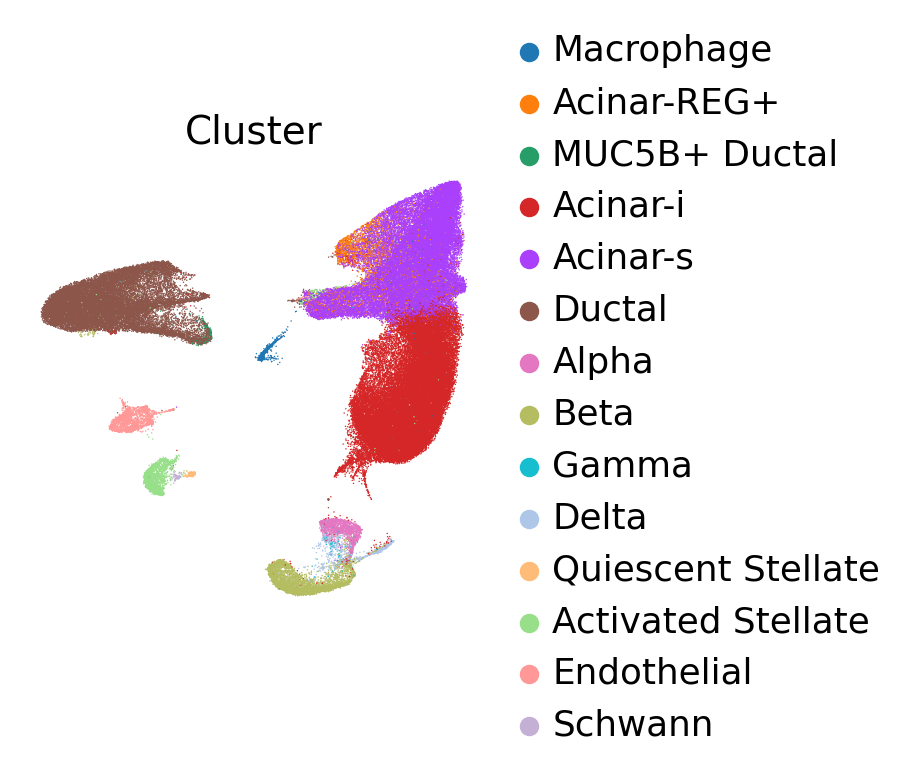

In [42]:
sc.pl.umap(adata_tosti, color='Cluster',frameon=False, save='tosti.pdf')

In [6]:
adata_tosti.layers['counts'] = adata_tosti.X
adata_tosti.obs['cell_type'] = adata_tosti.obs['Cluster']

In [7]:
folder = '/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/'
file   = 'dissociated_nd_annotation_l0.h5ad'

adata_sander  = sc.read(filename = folder+file)
adata_sander

AnnData object with n_obs × n_vars = 21453 × 23146
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'cell_type_coarse'
    var: 'n_cells'
    uns: 'Sample_colors', 'cell_type_coarse_colors', 'cell_type_coarse_sizes', 'dendrogram_cell_type_coarse', 'leiden', 'log1p', 'neighbors', 'paga', 'phase_colors'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts', 'soupX_counts'
    obsp: 'connectivities', 'distances'

In [8]:
cluster2annotation = {
    'Alpha' : 'Alpha',
    'Beta' : 'Beta',
    'Delta' : 'Endocrine',
    'Ductal' : 'Ductal',
    'Ductal_Acinar_MUC1_AMY2A' : 'Acinar', #Ductal
    'Immune' : 'Immune',
    'T-cells' : 'Immune',
    'Fibroblasts' : 'Fibroblasts',
    'Endothelial' : 'Endothelial',
    'Lymphatic' : 'Endothelial',
    'Acinar_OLFM4+' : 'Acinar', 
    'Acinar' : 'Acinar'
}

adata_sander.obs['cell_type'] = adata_sander.obs['cell_type_coarse'].map(cluster2annotation).astype('category')

adata_sander.obs['cell_type'].cat.reorder_categories(['Acinar','Alpha','Beta','Ductal','Endocrine','Endothelial',
                                                         'Fibroblasts','Immune'])#,inplace=True)

AAACCCAGTGGTCTCG-1         Acinar
AAACCCATCCATCCGT-1         Acinar
AAACGAATCGAAATCC-1         Acinar
AAACGAATCGCCTAGG-1         Acinar
AAACGCTAGGCTAACG-1         Acinar
                         ...     
TTTGTTGGTGAGTAGC-1         Acinar
TTTGTTGGTGTATACC-1         Acinar
TTTGTTGGTGTCCACG-1         Acinar
TTTGTTGTCAACTGGT-1    Fibroblasts
TTTGTTGTCGTTAGAC-1         Acinar
Name: cell_type, Length: 21453, dtype: category
Categories (8, object): ['Acinar', 'Alpha', 'Beta', 'Ductal', 'Endocrine', 'Endothelial', 'Fibroblasts', 'Immune']

In [9]:
adata_sander.obs['sample_ID'] = adata_sander.obs['Sample']

In [ ]:
sc.concat

In [10]:
adata = sc.concat([adata_tosti, adata_sander],label='study')
adata

AnnData object with n_obs × n_vars = 134016 × 18486
    obs: 'sample_ID', 'cell_type', 'study'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

### Data pre-processing for integration using scvi

In [11]:
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="study",
    subset=True,
)

### Integration with scVI

In [12]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="sample_ID")

Outdated cuDNN installation found.
Version JAX was built against: 8906
Minimum supported: 8900
Installed version: 8700
The local installation version must be no lower than 8900..(Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [13]:
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [14]:
model.train()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 3g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 3g.20gb') that has Te

Epoch 60/60: 100%|██████████| 60/60 [07:46<00:00,  7.84s/it, v_num=1, train_loss_step=279, train_loss_epoch=289]

INFO: `Trainer.fit` stopped: `max_epochs=60` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch 60/60: 100%|██████████| 60/60 [07:46<00:00,  7.78s/it, v_num=1, train_loss_step=279, train_loss_epoch=289]


In [15]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [16]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata)

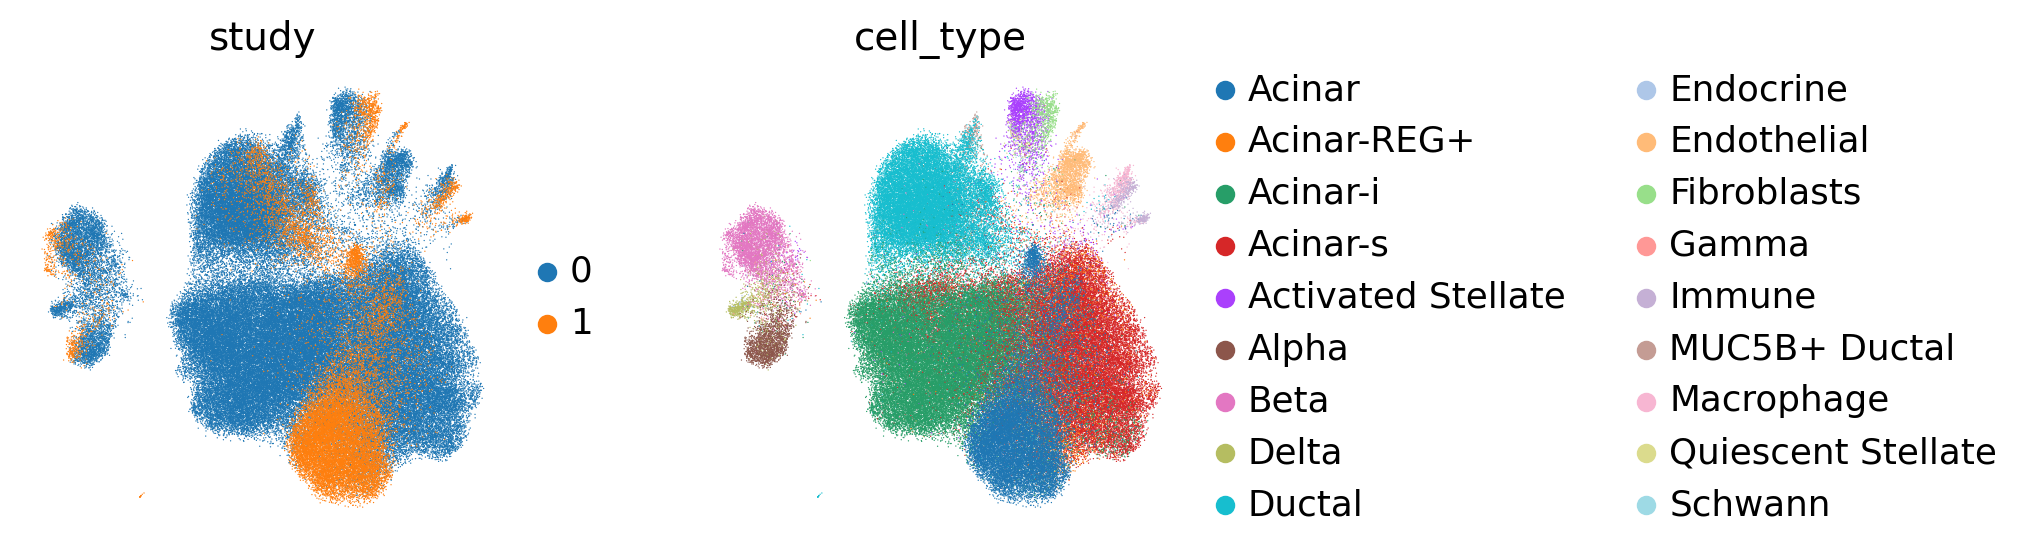

In [17]:
sc.pl.umap(adata, color=['study','cell_type'], frameon=False)

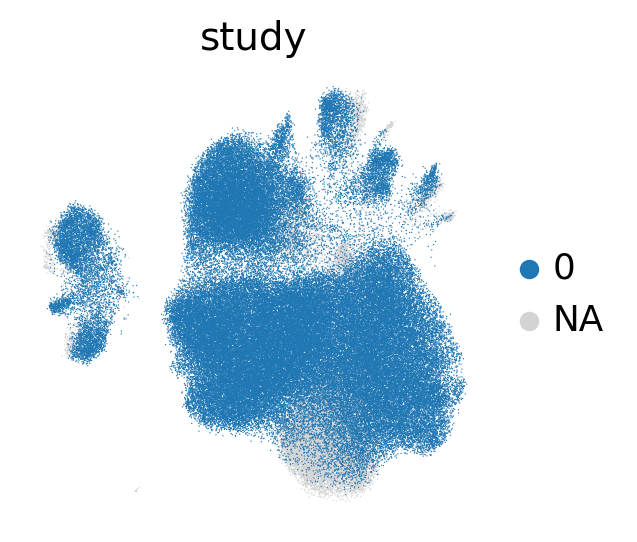

In [18]:
sc.pl.umap(adata, color=['study'], groups=['0'] , frameon=False)

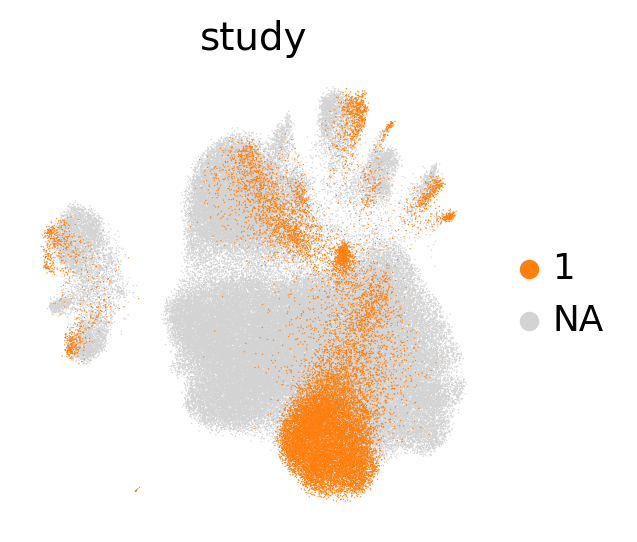

In [19]:
sc.pl.umap(adata, color=['study'], groups=['1'] , frameon=False)

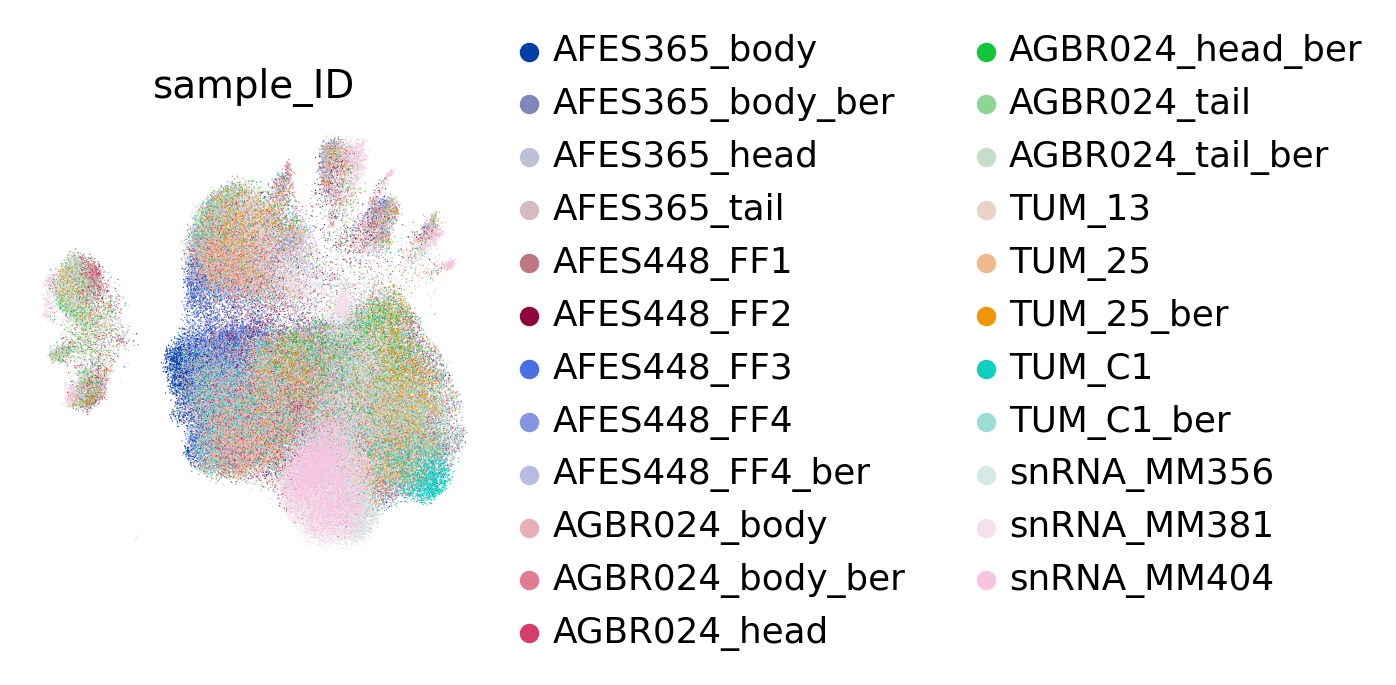

In [20]:
sc.pl.umap(adata, color=['sample_ID'] , frameon=False)

### Reference - query split for scPoli

In [21]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_prototype_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

condition_key = 'sample_ID'
cell_type_key = 'cell_type'
reference = ['0']
query = ['1']

In [22]:
adata.obs['query'] = adata.obs['study'].isin(query)
adata.obs['query'] = adata.obs['query'].astype('category')
source_adata = adata[adata.obs.study.isin(reference)].copy()
target_adata = adata[adata.obs.study.isin(query)].copy()

In [23]:
source_adata, target_adata

(AnnData object with n_obs × n_vars = 112563 × 2000
     obs: 'sample_ID', 'cell_type', 'study', '_scvi_batch', '_scvi_labels', 'query'
     var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
     uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'study_colors', 'cell_type_colors', 'sample_ID_colors'
     obsm: 'X_pca', 'X_umap', 'X_scVI'
     layers: 'counts'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 21453 × 2000
     obs: 'sample_ID', 'cell_type', 'study', '_scvi_batch', '_scvi_labels', 'query'
     var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
     uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'study_colors', 'cell_type_colors', 'sample_ID_colors'
     obsm: 'X_pca', 'X_umap', 'X_scVI'
     layers: 'counts'
     obsp: 'distances', 'connectivities')

In [24]:
sc.pp.subsample(source_adata,fraction=0.1)
source_adata

AnnData object with n_obs × n_vars = 11256 × 2000
    obs: 'sample_ID', 'cell_type', 'study', '_scvi_batch', '_scvi_labels', 'query'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'study_colors', 'cell_type_colors', 'sample_ID_colors'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

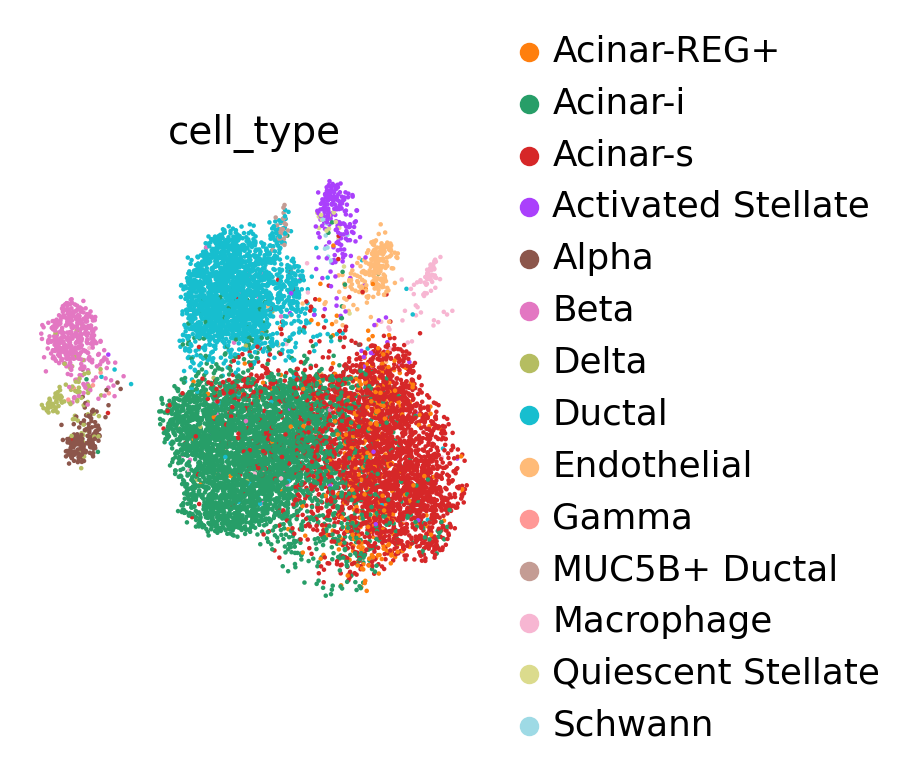

In [25]:
sc.pl.umap(source_adata, color=['cell_type'], frameon=False)

### Train reference scPoli model on fully labeled reference data

In [26]:
scpoli_model = scPoli(
    adata=source_adata,
    condition_keys=condition_key,
    cell_type_keys=cell_type_key,
    embedding_dims=3,
    recon_loss='nb',
)
scpoli_model.train(
    n_epochs=50,
    pretraining_epochs=40,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=5,
)

Embedding dictionary:
 	Num conditions: [20]
 	Embedding dim: [3]
Encoder Architecture:
	Input Layer in, out and cond: 2000 45 3
	Mean/Var Layer in/out: 45 10
Decoder Architecture:
	First Layer in, out and cond:  10 45 3
	Output Layer in/out:  45 2000 



INFO:scarches.trainers.scpoli.trainer:GPU available: True, GPU used: True


Initializing dataloaders
Starting training
 |████████████████████| 100.0%  - val_loss:  369.27 - val_cvae_loss:  355.04 - val_prototype_loss:   14.23 - val_labeled_loss:    2.85


### Reference mapping of unlabeled query datasets

In [27]:
scpoli_query = scPoli.load_query_data(
    adata=target_adata,
    reference_model=scpoli_model,
    labeled_indices=[],
)

Embedding dictionary:
 	Num conditions: [23]
 	Embedding dim: [3]
Encoder Architecture:
	Input Layer in, out and cond: 2000 45 3
	Mean/Var Layer in/out: 45 10
Decoder Architecture:
	First Layer in, out and cond:  10 45 3
	Output Layer in/out:  45 2000 



In [28]:
scpoli_query.train(
    n_epochs=50,
    pretraining_epochs=40,
    eta=10
)

INFO:scarches.trainers.scpoli.trainer:GPU available: True, GPU used: True


The missing labels are: {'Endocrine', 'Fibroblasts', 'Acinar', 'Immune'}
Therefore integer value of those labels is set to -1
The missing labels are: {'Endocrine', 'Fibroblasts', 'Acinar', 'Immune'}
Therefore integer value of those labels is set to -1
The missing labels are: {'Endocrine', 'Fibroblasts', 'Acinar', 'Immune'}
Therefore integer value of those labels is set to -1
The missing labels are: {'Endocrine', 'Fibroblasts', 'Acinar', 'Immune'}
Therefore integer value of those labels is set to -1
Initializing dataloaders
Starting training
 |████████████████----| 80.0%  - val_loss:  455.22 - val_cvae_loss:  455.22
Initializing unlabeled prototypes with Leiden with an unknown number of  clusters.
Clustering succesful. Found 35 clusters.
 |████████████████████| 100.0%  - val_loss:  457.46 - val_cvae_loss:  457.46 - val_prototype_loss:    0.00 - val_unlabeled_loss:    0.20


### Label transfer from reference to query

In [29]:
results_dict = scpoli_query.classify(target_adata, scale_uncertainties=True)

check the label transfer performance we achieved

In [30]:
for i in range(len(cell_type_key)):
    preds = results_dict[cell_type_key]["preds"]
    results_dict[cell_type_key]["uncert"]
    classification_df = pd.DataFrame(
        classification_report(
            y_true=target_adata.obs[cell_type_key],
            y_pred=preds,
            output_dict=True,
        )
    ).transpose()
print(classification_df)

                    precision    recall  f1-score       support
Acinar               0.000000  0.000000  0.000000  16762.000000
Acinar-REG+          0.000000  0.000000  0.000000      0.000000
Acinar-i             0.000000  0.000000  0.000000      0.000000
Acinar-s             0.000000  0.000000  0.000000      0.000000
Activated Stellate   0.000000  0.000000  0.000000      0.000000
Alpha                0.991111  0.681957  0.807971    327.000000
Beta                 0.960674  0.763393  0.850746    448.000000
Delta                0.000000  0.000000  0.000000      0.000000
Ductal               0.996430  0.792055  0.882565   2467.000000
Endocrine            0.000000  0.000000  0.000000     29.000000
Endothelial          0.919149  0.955752  0.937093    226.000000
Fibroblasts          0.000000  0.000000  0.000000    716.000000
Gamma                0.000000  0.000000  0.000000      0.000000
Immune               0.000000  0.000000  0.000000    478.000000
MUC5B+ Ductal        0.000000  0.000000 

In [31]:
#get latent representation of reference data
scpoli_query.model.eval()
data_latent_source = scpoli_query.get_latent(
    source_adata,
    mean=True
)

adata_latent_source = sc.AnnData(data_latent_source)
adata_latent_source.obs = source_adata.obs.copy()

#get latent representation of query data
data_latent= scpoli_query.get_latent(
    target_adata,
    mean=True
)

adata_latent = sc.AnnData(data_latent)
adata_latent.obs = target_adata.obs.copy()

#get label annotations
adata_latent.obs['cell_type_pred'] = results_dict['cell_type']['preds'].tolist()
adata_latent.obs['cell_type_uncert'] = results_dict['cell_type']['uncert'].tolist()
adata_latent.obs['classifier_outcome'] = (
    adata_latent.obs['cell_type_pred'] == adata_latent.obs['cell_type']
)

#get prototypes
labeled_prototypes = scpoli_query.get_prototypes_info()
labeled_prototypes.obs['study'] = 'labeled prototype'
unlabeled_prototypes = scpoli_query.get_prototypes_info(prototype_set='unlabeled')
unlabeled_prototypes.obs['study'] = 'unlabeled prototype'

#join adatas
adata_latent_full = adata_latent_source.concatenate(
    [adata_latent, labeled_prototypes, unlabeled_prototypes],
    batch_key='query'
)
adata_latent_full.obs['cell_type_pred'][adata_latent_full.obs['query'].isin(['0'])] = np.nan
sc.pp.neighbors(adata_latent_full, n_neighbors=15)
sc.tl.umap(adata_latent_full)

In [32]:
#get adata without prototypes
adata_no_prototypes = adata_latent_full[adata_latent_full.obs['query'].isin(['0', '1'])]

<Axes: title={'center': 'cell_type_pred'}, xlabel='UMAP1', ylabel='UMAP2'>

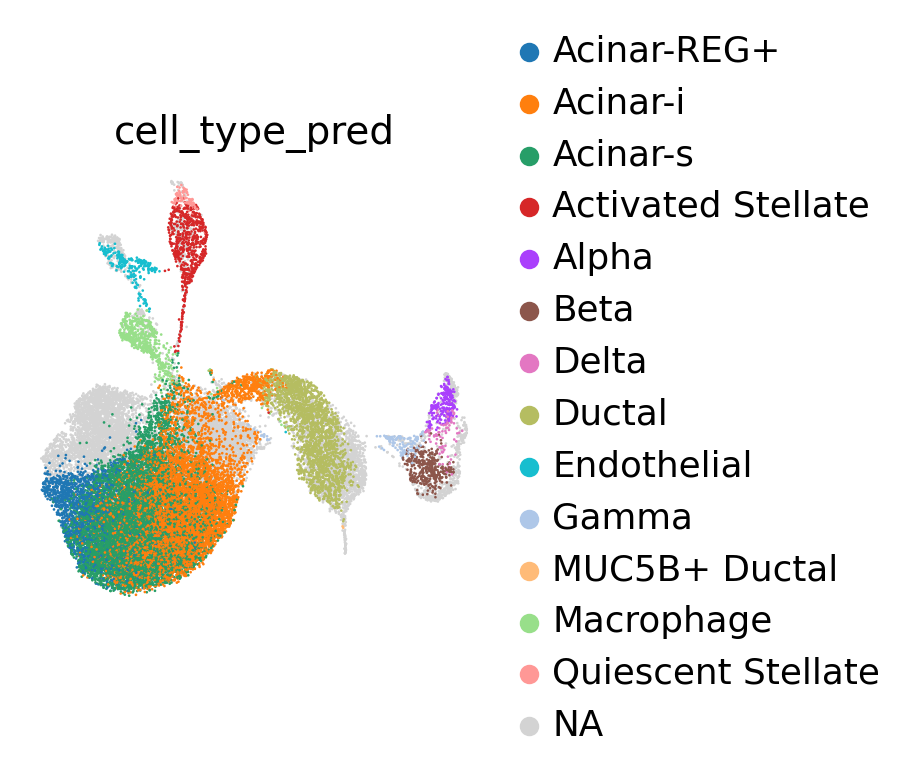

In [33]:
sc.pl.umap(
    adata_no_prototypes,
    color='cell_type_pred',
    show=False,
    frameon=False,
)

<Axes: title={'center': 'cell_type_uncert'}, xlabel='UMAP1', ylabel='UMAP2'>

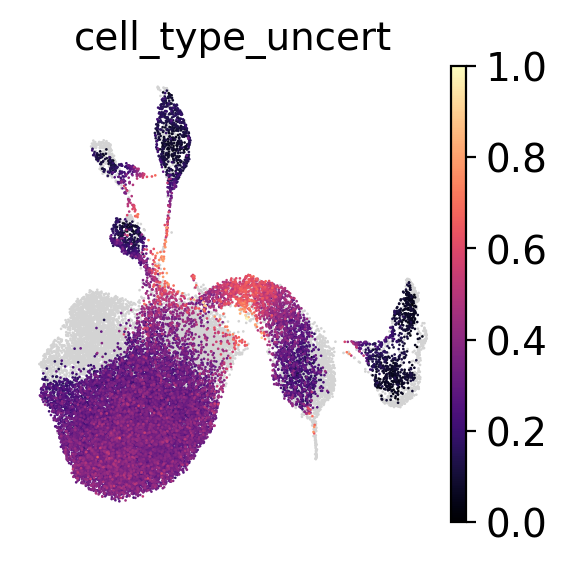

In [34]:
# Inspect uncertainty
sc.pl.umap(
    adata_no_prototypes,
    color='cell_type_uncert',
    show=False,
    frameon=False,
    cmap='magma',
    vmax=1
)

<Axes: title={'center': 'study'}, xlabel='UMAP1', ylabel='UMAP2'>

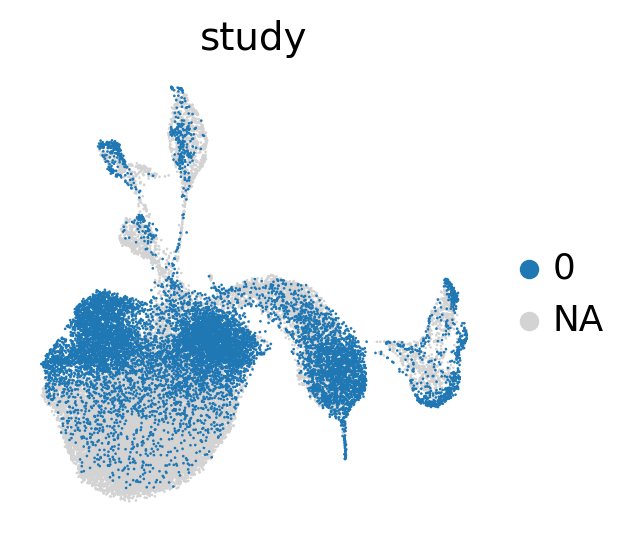

In [35]:
sc.pl.umap(
    adata_no_prototypes,
    color='study',groups=['0'],
    show=False,
    frameon=False,
)

<Axes: title={'center': 'study'}, xlabel='UMAP1', ylabel='UMAP2'>

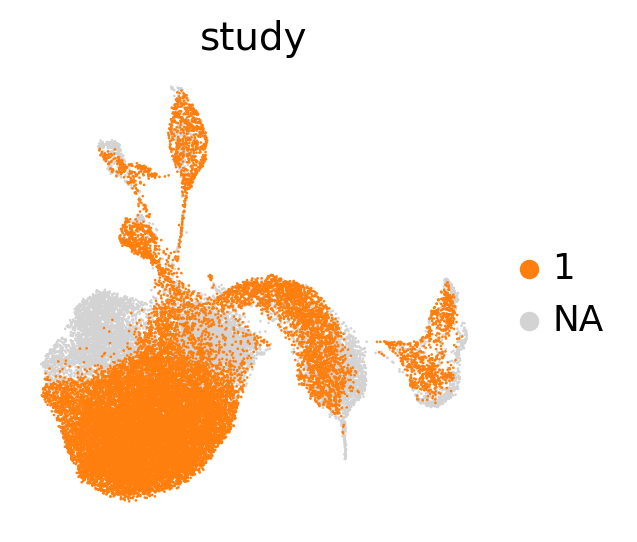

In [36]:
sc.pl.umap(
    adata_no_prototypes,
    color='study',groups=['1'],
    show=False,
    frameon=False,
)

In [ ]:
adata_no_prototypes

In [ ]:
adata_no_prototypes.obs.cell_type_pred.unique()

In [ ]:
adata_no_prototypes.obs.cell_type_pred[adata_no_prototypes.obs.study.isin(query)]

In [37]:
tosti_ann = adata_no_prototypes.obs.cell_type_pred[adata_no_prototypes.obs.study.isin(query)]
range(len(tosti_ann))

range(0, 21453)

In [38]:
tosti_ann = adata_no_prototypes.obs.cell_type_pred[adata_no_prototypes.obs.study.isin(query)]
index_name_without_suffix=[]
for i in range(len(tosti_ann)):
    index_name = tosti_ann.index[i]
    index_name_without_suffix.append(index_name[:-2])
    #tosti_ann.index[i] = index_name_without_suffix
tosti_ann.index = index_name_without_suffix
tosti_ann

AAACCCAGTGGTCTCG-1           Acinar-REG+
AAACCCATCCATCCGT-1              Acinar-s
AAACGAATCGAAATCC-1              Acinar-s
AAACGAATCGCCTAGG-1           Acinar-REG+
AAACGCTAGGCTAACG-1              Acinar-s
                             ...        
TTTGTTGGTGAGTAGC-1              Acinar-s
TTTGTTGGTGTATACC-1              Acinar-s
TTTGTTGGTGTCCACG-1              Acinar-i
TTTGTTGTCAACTGGT-1    Activated Stellate
TTTGTTGTCGTTAGAC-1              Acinar-s
Name: cell_type_pred, Length: 21453, dtype: category
Categories (13, object): ['Acinar-REG+', 'Acinar-i', 'Acinar-s', 'Activated Stellate', ..., 'Gamma', 'MUC5B+ Ductal', 'Macrophage', 'Quiescent Stellate']

In [ ]:
adata_sander.obs_names

In [39]:
adata_sander.obs['Tosti_ann'] = tosti_ann
adata_sander

AnnData object with n_obs × n_vars = 21453 × 23146
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'cell_type_coarse', 'cell_type', 'sample_ID', 'Tosti_ann'
    var: 'n_cells'
    uns: 'Sample_colors', 'cell_type_coarse_colors', 'cell_type_coarse_sizes', 'dendrogram_cell_type_coarse', 'leiden', 'log1p', 'neighbors', 'paga', 'phase_colors'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts', 'soupX_counts'
    obsp: 'connectivities', 'distances'

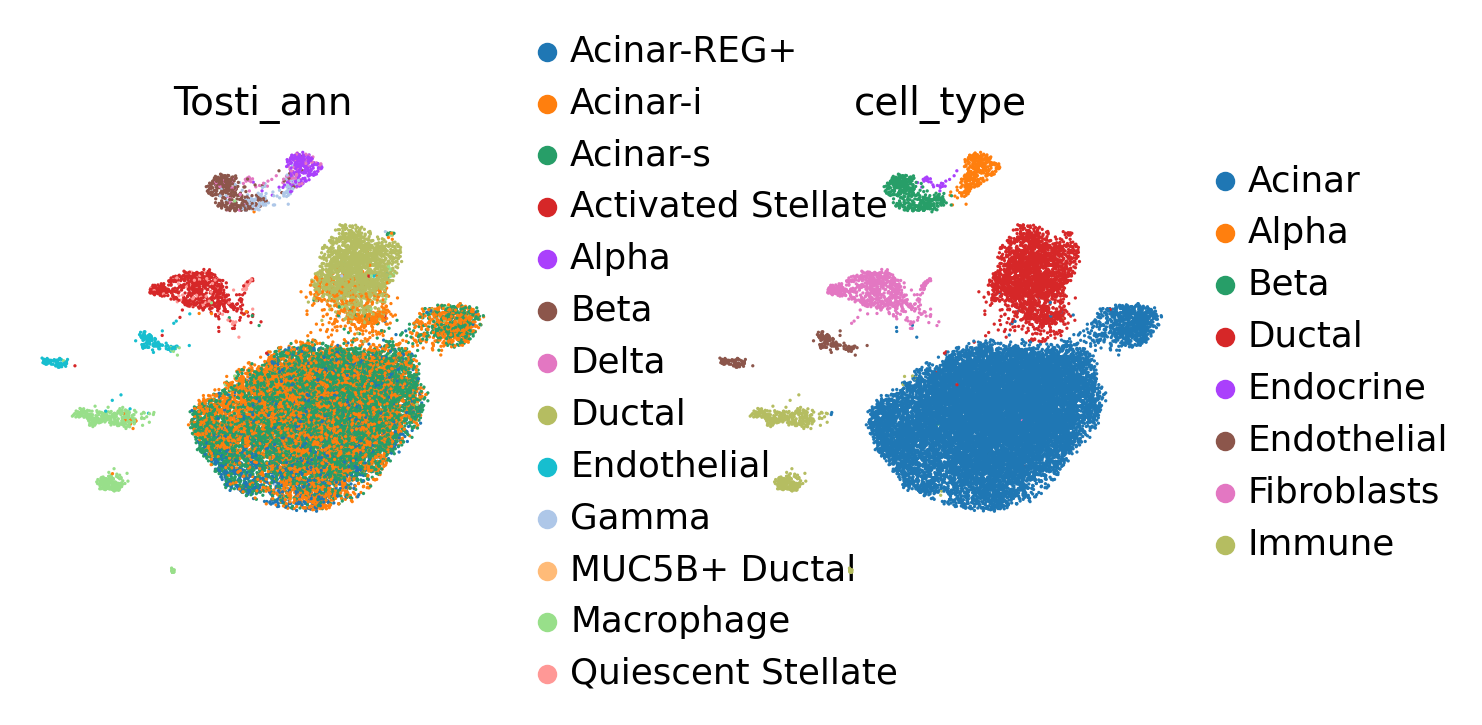

In [40]:
sc.pl.umap(adata_sander, color=['Tosti_ann','cell_type'], frameon=False)

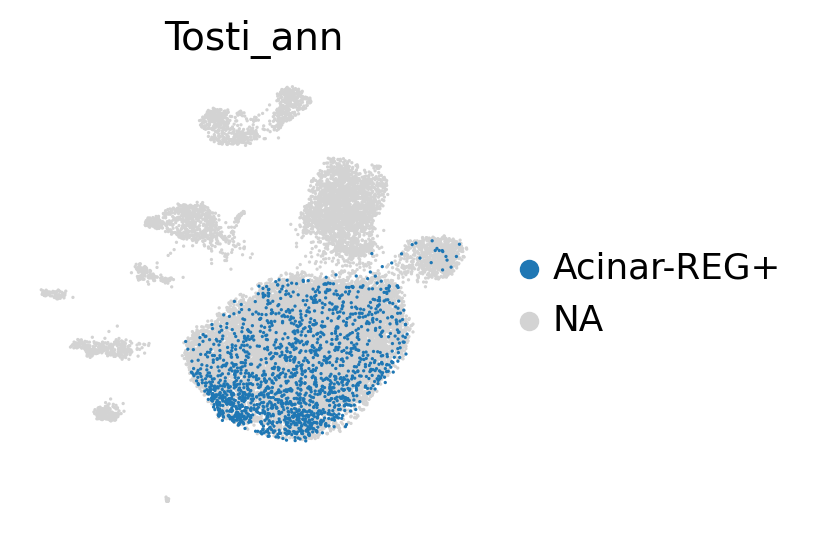

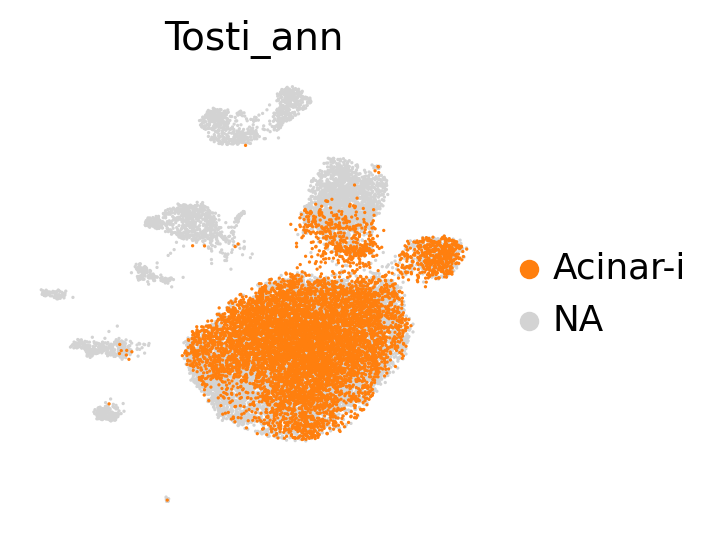

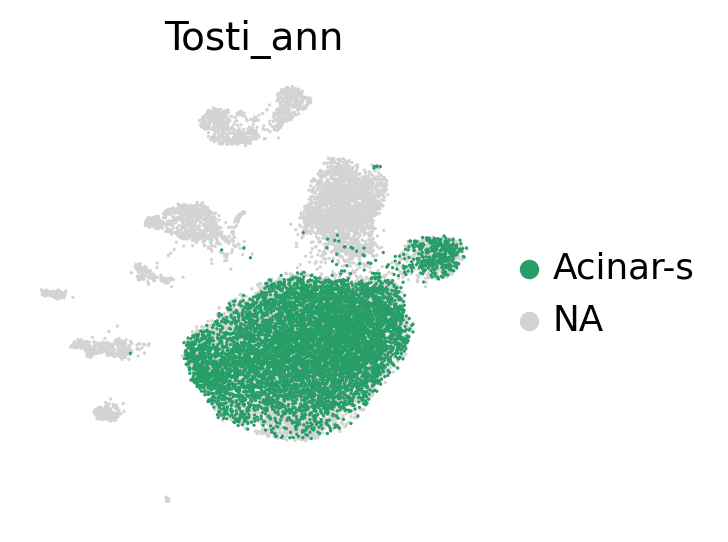

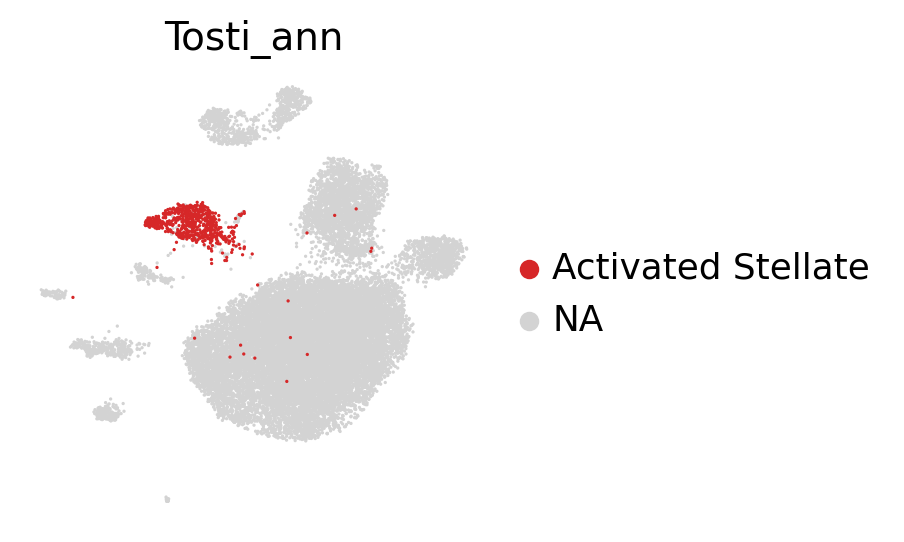

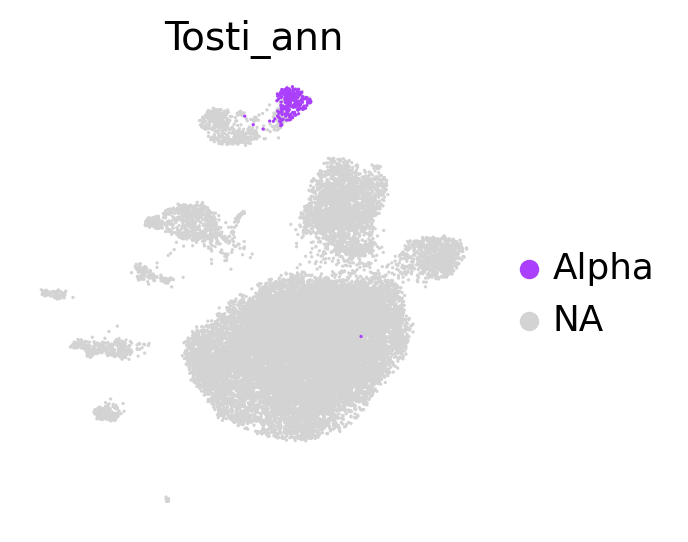

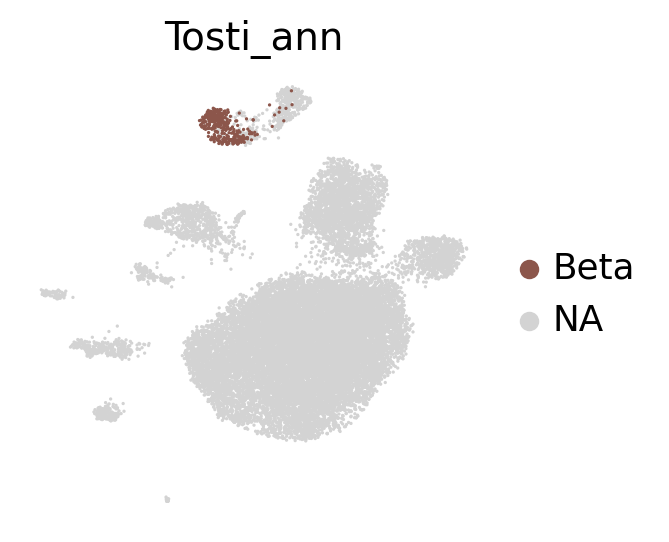

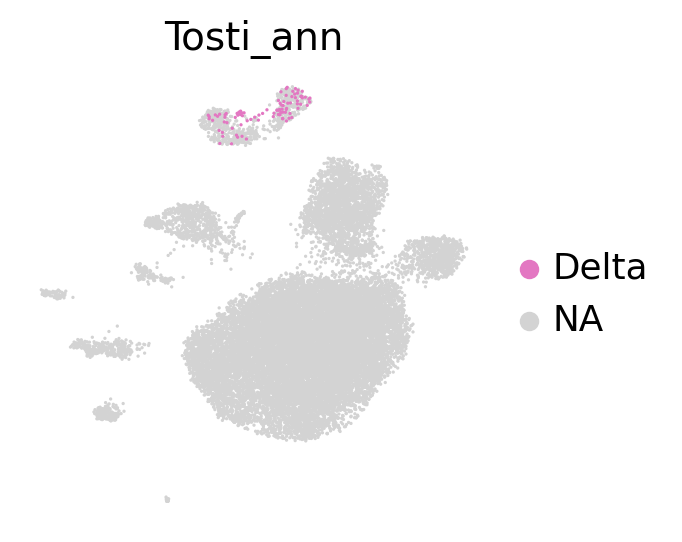

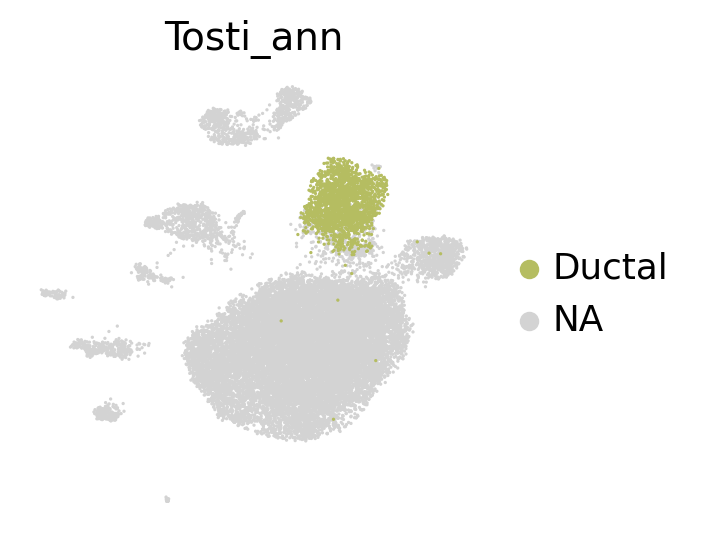

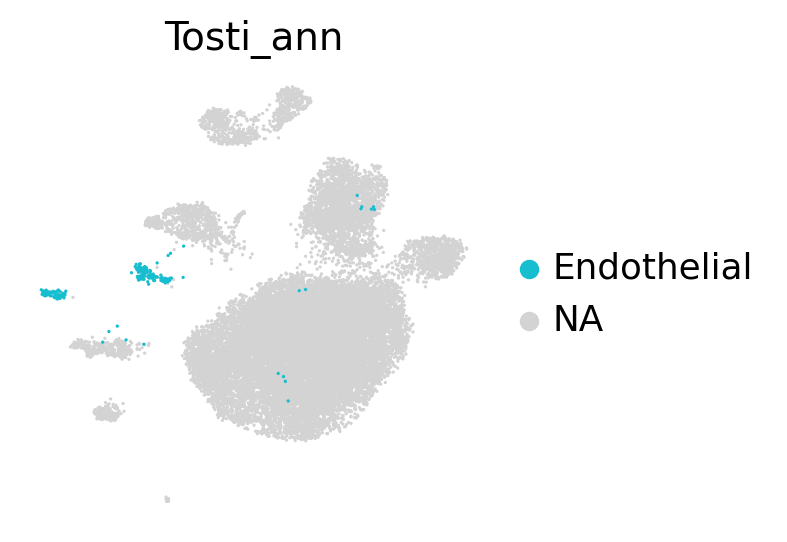

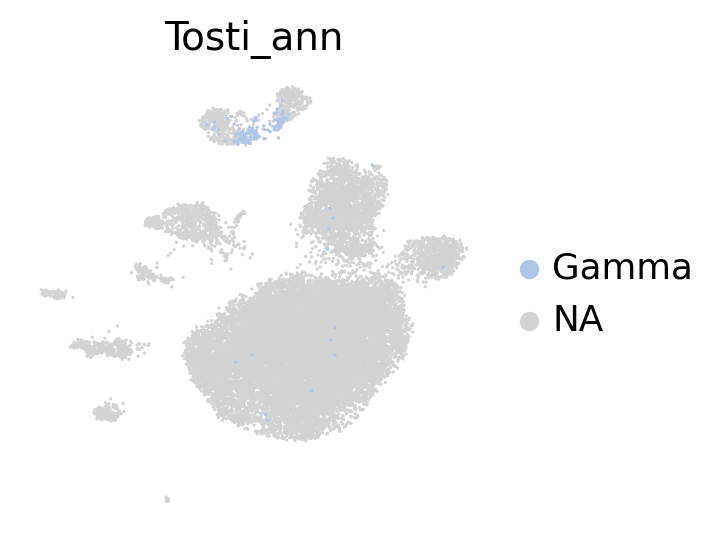

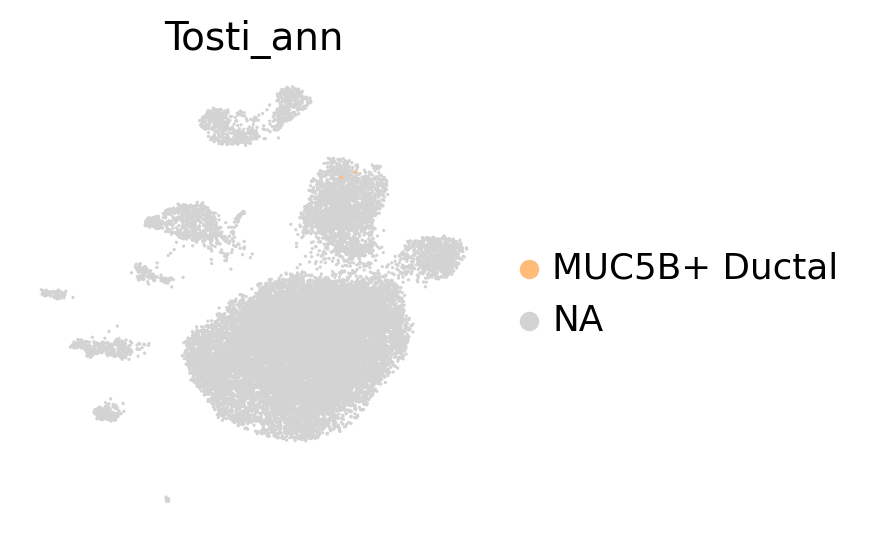

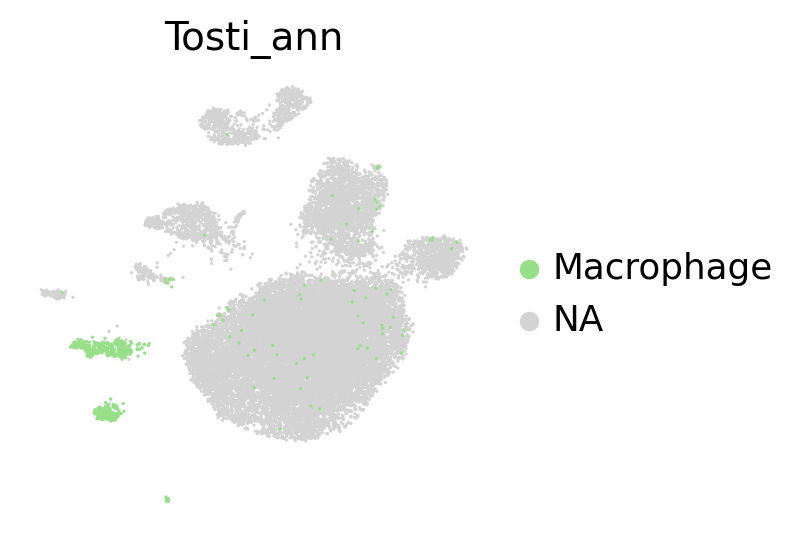

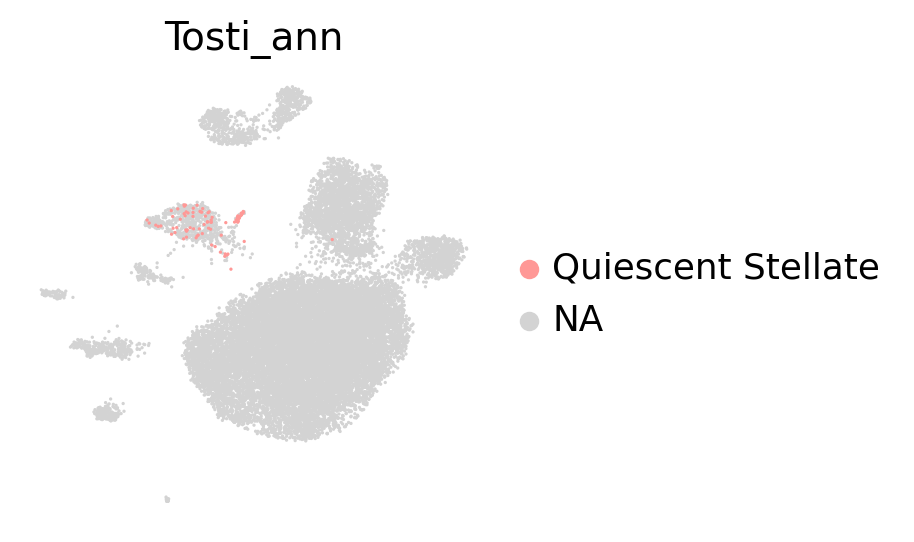

In [41]:
for i in adata_sander.obs.Tosti_ann.cat.categories:
    sc.pl.umap(adata_sander, color=['Tosti_ann'], groups=i, frameon=False)